# New Method again

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import confusion_matrix_handling as cm_handling
from confusion_matrix_handling import MODE_MAPPING_DICT
import helper_functions as helper

In [503]:
'''
inputCM: a dataframe of column normalized counts (so of P(actual|predicted)), columns = sensed, rows = actual modes
predictions: a Series of predicted counts per mode
NMC: number of times to repeat
'''

def new_method(inputCM, predictions):
    # get column predictions from inputCM
    column_probabilities = inputCM
    print("probabilities:\n", column_probabilities)
    mean = {}
    variance = {}
    # calculate mean per mode
    for index, row in column_probabilities.iterrows():
        mean[index] = (row*predictions).sum()
    
    # calculate variance per mode
    for index, row in column_probabilities.iterrows():
        print(index, ":\n", predictions*row*(1-row))
        variance[index] =  (predictions*row*(1-row)).sum()
    
    return(pd.Series(mean), pd.Series(variance))

# plotting results

In [493]:
def plot_results(estimated_values, actual_values, sd, y_lab, title):
    # find max value in est and actual
    max_val = 0
    if estimated_values.max() > actual_values.max():
        max_val = estimated_values.max()
    elif estimated_values.max() < actual_values.max():
        max_val = actual_values.max()
    else: max_val = estimated_values.max()
    
    # group data: if less than 20% of max, put in a subplot
    big_plot = pd.DataFrame(columns = ["estimated", "actual", "sd"])
    small_plot = pd.DataFrame(columns = ["estimated", "actual", "sd"])
    for mode in estimated_values.index:
        if (estimated_values[mode] > (0.2 * max_val)) or (actual_values[mode] > (0.2 * max_val)):
            big_plot = big_plot.append(pd.DataFrame({
                    "estimated":[estimated_values[mode]],
                    "actual": [actual_values[mode]],
                    "sd": [sd[mode]],
                    "mode_lab": mode
                }), ignore_index = True)
        else:
            small_plot = small_plot.append(pd.DataFrame({
                    "estimated":[estimated_values[mode]],
                    "actual": [actual_values[mode]],
                    "sd":[sd[mode]],
                    "mode_lab": mode
                }), ignore_index = True)
            
    width = 0.5

    fig, axis = plt.subplots(1, 2)
    axis[0] = plt.subplot(121)
    axis[0].bar(np.arange(len(big_plot.index)), big_plot.estimated, yerr = big_plot.sd, color = 'orange', width = width, label = 'expected', capsize= 5)
    axis[0].bar(np.arange(len(big_plot.index)) + width, big_plot.actual, color = 'cornflowerblue', width = width, label = 'actual', capsize= 5)
    axis[0].set_xticks(np.arange(len(big_plot.index)))
    axis[0].set_xticklabels(big_plot.mode_lab.values, fontsize=22)
    axis[0].tick_params(axis='both', which='major', labelsize=22)

    axis[1] = plt.subplot(122)
    axis[1].bar(np.arange(len(small_plot.index)), small_plot.estimated, yerr = small_plot.sd, color = 'orange', width = width, label = 'expected', capsize= 5)
    axis[1].bar(np.arange(len(small_plot.index)) + width, small_plot.actual, color = 'cornflowerblue', width = width, label = 'actual', capsize= 5)
    axis[1].set_xticklabels(small_plot.mode_lab.values)
    axis[1].set_xticks(np.arange(len(small_plot.index)))
    axis[1].set_xticklabels(small_plot.mode_lab.values, fontsize=22)
    # axis[1].set_yticklabels(fontsize=22)
    axis[1].tick_params(axis='both', which='major', labelsize=22)

    fig.text(0.55, 0.04, "Mode",fontsize = 24, ha='center')
    fig.text(0.2, 0.5, y_lab, fontsize = 24, va='center', rotation='vertical')

    fig.suptitle(title,fontsize = 36, x=0.65)
    # fig.tight_layout()

    plt.legend(prop={'size': 18})
    plt.subplots_adjust(top=0.9, bottom=0.2, left = 0.3, right=1.1)
    plt.show()

In [460]:
'''
Toy example
TODO: try with new toy dataset
'''
predicted_bike = [80, 10, 10] #bike, walk, car
predicted_walk = [5, 75, 20]
predicted_car =  [15, 15, 70]

cm = pd.DataFrame({'bike':predicted_bike, 'walk':predicted_walk, 'car':predicted_car}, index=['bike', 'walk', 'car'])
predictions = pd.Series({'car': 4, 'bike': 10, 'walk':6})
actual = pd.Series({'car': 6, 'bike': 8, 'walk':6})

(mean, var) =  new_method(cm/cm.sum(axis=0), predictions)
print(pd.DataFrame({"predictions":predictions, "actual": actual, "mean": mean, "var":var, "sd from actual":(mean.subtract(actual))/(np.sqrt(var))}))

probabilities:
       bike  walk   car
bike   0.8  0.05  0.15
walk   0.1  0.75  0.15
car    0.1  0.20  0.70
      predictions  actual  mean    var  sd from actual
bike           10       8   8.9  2.395        0.581554
car             4       6   5.0  2.700       -0.608581
walk            6       6   6.1  2.535        0.062807


#  All_CEO -> Durham counts

In [394]:
# get All_CEO CM collapsed to sensed modes
all_ceo_trips = pd.read_csv("trip_data/all_ceo_trip_data.csv")
all_ceo_counts = cm_handling.pair_matching(all_ceo_trips, by_distances=False)
all_ceo_counts = cm_handling.map_labels(all_ceo_counts, MODE_MAPPING_DICT, remove_unknown=True)

# collapse to base modes
all_ceo_gt_to_sensed_mode_map = {
    "bicycling":["Bikeshare", "Pilot ebike", "Regular Bike"],
    "car": ["Gas Car, drove alone", "Gas Car, with others", "Taxi/Uber/Lyft", "E-car, drove alone"],
    "train": ["Train"],
    "walking": ["Walk"],
    "bus": ["Bus", "Free Shuttle"]
}

all_ceo_counts = cm_handling.collapse_confusion_matrix(all_ceo_counts, rows_to_collapse=all_ceo_gt_to_sensed_mode_map, columns_to_collapse={})
all_ceo_counts = cm_handling.drop_rows_and_columns(all_ceo_counts, row_list=["Air", "Not a Trip", "Scooter share", "Skate board"], column_list=["no_sensed", "air_or_hsr", "subway"])
all_ceo_counts = all_ceo_counts.sort_index()

print(all_ceo_counts)
all_ceo_counts = all_ceo_counts.reindex(sorted(all_ceo_counts.columns), axis=1)
# print(all_ceo_counts.to_latex())

               car  walking  bicycling    bus  train
bicycling   6374.0   7581.0     9766.0   73.0   10.0
bus          891.0    535.0      114.0   30.0    9.0
car        33309.0   5910.0     1008.0  359.0   21.0
train         45.0     41.0       15.0    2.0   66.0
walking     1173.0  12559.0      485.0   68.0    2.0


In [479]:
# get durham data collapsed to sensed modes

durham_trip_data = pd.read_csv("trip_data/durham_trip_data.csv")

durham_counts = cm_handling.pair_matching(durham_trip_data, by_distances=False)
durham_counts = cm_handling.map_labels(durham_counts, MODE_MAPPING_DICT, remove_unknown=True)
print(durham_counts)
durham_gt_to_sensed_mode_map = {
    "bicycling":["Bikeshare", "Pilot ebike", "Regular Bike"],
    "car": ["Gas Car, drove alone", "Gas Car, with others", "Taxi/Uber/Lyft", "E-car, drove alone", "E-car, with others"],
    "train": ["Train"],
    "walking": ["Walk"],
    "bus": ["Bus", "Free Shuttle"]
}

durham_counts = cm_handling.collapse_confusion_matrix(durham_counts, rows_to_collapse=durham_gt_to_sensed_mode_map, columns_to_collapse={})
durham_counts = cm_handling.drop_rows_and_columns(durham_counts, row_list=["Air",  "Not a Trip", "Scooter share"], column_list=["no_sensed", "air_or_hsr", "subway"])
durham_counts = durham_counts.sort_index()

print(durham_counts)
durham_counts = durham_counts.reindex(sorted(durham_counts.columns), axis=1)
# print(durham_counts.to_latex())

                      walking     car  train  no_sensed   bus  air_or_hsr  \
Air                       4.0     1.0    1.0        0.0   0.0         6.0   
Bikeshare                 1.0     0.0    0.0        0.0   0.0         0.0   
Bus                      11.0    58.0    0.0        3.0  15.0         0.0   
E-car, drove alone        2.0    14.0    0.0        1.0   0.0         0.0   
E-car, with others        4.0    28.0    0.0        1.0   0.0         0.0   
Free Shuttle              1.0     0.0    0.0        0.0   0.0         0.0   
Gas Car, drove alone    178.0  1194.0    2.0       27.0   2.0         0.0   
Gas Car, with others    230.0   922.0    0.0       70.0  11.0         1.0   
Not a Trip               94.0    33.0    0.0       18.0   1.0         2.0   
Pilot ebike             553.0   573.0    0.0       85.0   9.0         1.0   
Regular Bike             42.0    54.0    0.0        7.0   2.0         1.0   
Scooter share             5.0     2.0    0.0        0.0   0.0         0.0   

probabilities:
            bicycling       bus       car     train   walking
bicycling   0.857569  0.137218  0.152517  0.092593  0.284722
bus         0.010011  0.056391  0.021320  0.083333  0.020093
car         0.088514  0.674812  0.797019  0.194444  0.221963
train       0.001317  0.003759  0.001077  0.611111  0.001540
walking     0.042589  0.127820  0.028068  0.018519  0.471682
bicycling :
 bicycling    145.351532
bus            4.735570
car          381.821407
train          0.168038
walking      363.728283
dtype: float64
bus :
 bicycling    11.793289
bus           2.128441
car          61.636194
train         0.152778
walking      35.165282
dtype: float64
car :
 bicycling     96.008554
bus            8.777630
car          477.898032
train          0.313272
walking      308.434523
dtype: float64
train :
 bicycling    1.565375
bus          0.149811
car          3.177327
train        0.475309
walking      2.745934
dtype: float64
walking :
 bicycling     48.522123
bus            4.45926

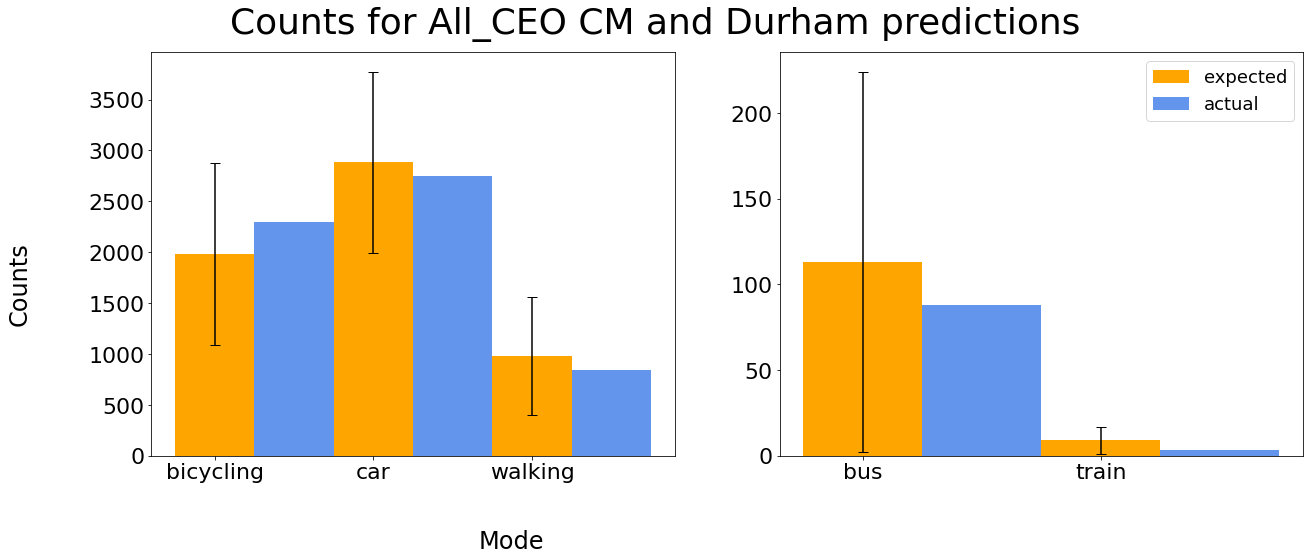

In [504]:
durham_predictions = durham_counts.sum(axis=0)
(mean, var) = new_method(all_ceo_counts/all_ceo_counts.sum(axis=0), durham_predictions)
print(pd.DataFrame({
    "actual": durham_counts.sum(axis=1),
    "predicted": durham_predictions,
    "expected": mean,
    "variance": var,
    "difference": mean.subtract(durham_counts.sum(axis=1)),
    "sd from actual": (mean.subtract(durham_counts.sum(axis=1))).div(np.sqrt(var))
}))
plot_results(mean, durham_counts.sum(axis=1), var, "Counts", "Counts for All_CEO CM and Durham predictions")

# durham -> all_ceo counts

In [157]:
all_ceo_counts = all_ceo_counts.reindex(sorted(all_ceo_counts.columns), axis=1)
durham_counts = durham_counts.reindex(sorted(durham_counts.columns), axis=1)
print(all_ceo_counts/all_ceo_counts.sum(axis=0))
print(durham_counts/durham_counts.sum(axis=0))

           bicycling       bus       car     train   walking
bicycling   0.857569  0.137218  0.152517  0.092593  0.284732
bus         0.010011  0.056391  0.021320  0.083333  0.020094
car         0.088514  0.674812  0.797019  0.194444  0.221934
train       0.001317  0.003759  0.001077  0.611111  0.001540
walking     0.042589  0.127820  0.028068  0.018519  0.471700
           bicycling    bus       car  train   walking
bicycling   0.894029  0.275  0.215316    0.0  0.334831
bus         0.002523  0.375  0.019918    0.0  0.006742
car         0.079058  0.325  0.745879    1.0  0.233146
train       0.000841  0.000  0.000000    0.0  0.001124
walking     0.023549  0.025  0.018887    0.0  0.424157


probabilities:
            bicycling    bus       car  train   walking
bicycling   0.893277  0.275  0.212255    0.0  0.333707
bus         0.002521  0.375  0.019634    0.0  0.006719
car         0.079832  0.325  0.749492    1.0  0.235722
train       0.000840  0.000  0.000000    0.0  0.001120
walking     0.023529  0.025  0.018619    0.0  0.422732
bicycling :
 bicycling    1085.651711
bus           106.067500
car          6987.729703
train           0.000000
walking      5920.198107
dtype: float64
bus :
 bicycling     28.636867
bus          124.687500
car          804.449386
train          0.000000
walking      177.696093
dtype: float64
car :
 bicycling     836.548761
bus           116.707500
car          7846.599921
train           0.000000
walking      4796.867978
dtype: float64
train :
 bicycling     9.561706
bus           0.000000
car           0.000000
train         0.000000
walking      29.782960
dtype: float64
walking :
 bicycling     261.648166
bus            12.967500
car         

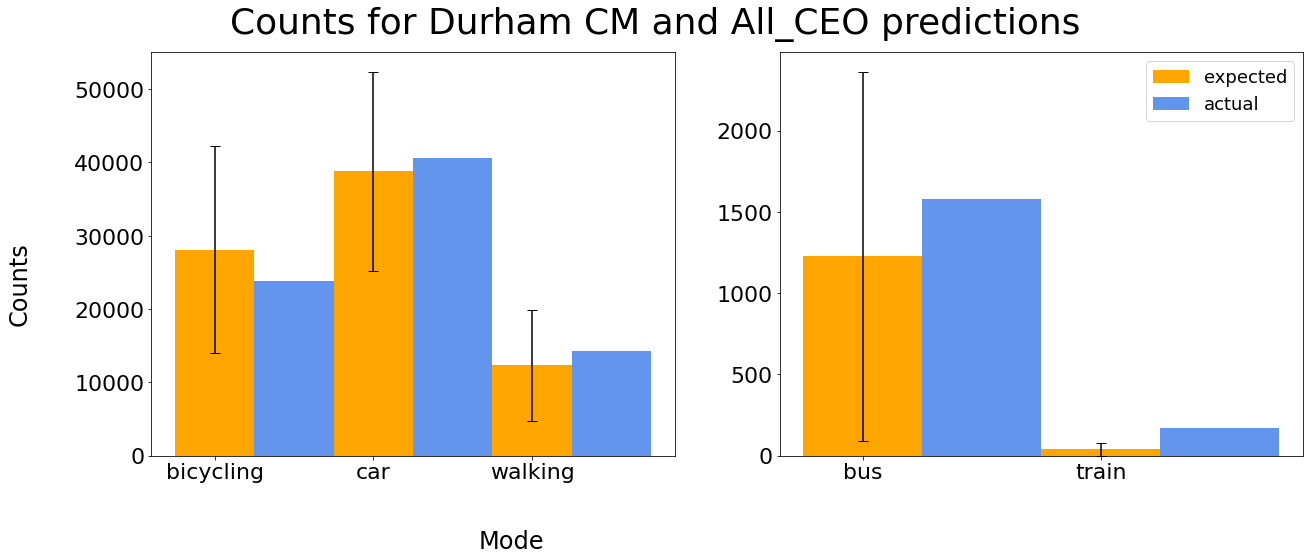

In [505]:
predictions = all_ceo_counts.sum(axis=0)
(mean, var) = new_method(durham_counts/durham_counts.sum(axis=0), predictions)
print(pd.DataFrame({
    "actual": all_ceo_counts.sum(axis=1),
    "predicted": predictions,
    "expected": mean,
    "variance": var,
    "difference": mean.subtract(all_ceo_counts.sum(axis=1)),
    "sd from actual": (mean.subtract(all_ceo_counts.sum(axis=1))).div(np.sqrt(var))
}))
plot_results(mean, all_ceo_counts.sum(axis=1), var, "Counts", "Counts for Durham CM and All_CEO predictions")

# MobilityNet -> All_CEO counts

In [339]:
# get MN CM collapsed to sensed modes
# get data

training_android = pd.read_csv("MobilityNetCMs/mobilitynet_duration_android.csv", index_col=0).T
training_ios = pd.read_csv("MobilityNetCMs/mobilitynet_duration_ios.csv", index_col=0).T

mobilityNet_counts = training_ios.add(training_android)
mobilityNet_counts = cm_handling.drop_rows_and_columns(mobilityNet_counts, row_list=["NO_GT_START", "NO_GT_MIDDLE", "NO_GT_END"], column_list=["NO_SENSED_START", "NO_SENSED_MIDDLE", "NO_SENSED_END", "UNKNOWN"])

mn_gt_to_sensed_mode_map = {
    "walking":["WALKING"],
    "car":["CAR"],
    "bicycling":["BICYCLING", "E_BIKE"],
    "train":["TRAIN", "LIGHT_RAIL"],
    "bus":["BUS"]
}

mobilityNet_counts = cm_handling.collapse_confusion_matrix(mobilityNet_counts, rows_to_collapse=mn_gt_to_sensed_mode_map, columns_to_collapse={})
mobilityNet_counts = cm_handling.drop_rows_and_columns(mobilityNet_counts, row_list=["ESCOOTER", "SUBWAY"], column_list=["AIR_OR_HSR", "LIGHT_RAIL", "SUBWAY"])
mobilityNet_counts.columns = map(lambda x: str(x).lower(), mobilityNet_counts.columns)
mobilityNet_counts = mobilityNet_counts.sort_index()

print(mobilityNet_counts)

              bicycling            bus           car          train  \
bicycling  59735.144755       0.000000      0.000000       0.000000   
bus          297.140356  110197.783889  35356.737340       0.000000   
car         3843.802353      43.047995  45190.028546       0.000000   
train       1657.933177   21530.771937  31796.654158  167371.711087   
walking     6116.379961    6942.442541   3963.397033    2566.104858   

                 walking  
bicycling    6680.445491  
bus          2578.760681  
car           246.559879  
train        4601.265893  
walking    136562.148444  


In [348]:
all_ceo_predictions = all_ceo_counts.sum(axis=0)
(mean, var) = new_method(mobilityNet_counts, all_ceo_predictions)
print(pd.DataFrame({
    "actual": all_ceo_counts.sum(axis=1),
    "predicted": all_ceo_predictions,
    "expected": mean,
    "variance": var,
    "sd from actual": (mean.subtract(all_ceo_counts.sum(axis=1))).div(np.sqrt(var))
}))

column normalized probabilities:
            bicycling       bus       car   train   walking
bicycling   0.833703  0.000000  0.000000  0.0000  0.044339
bus         0.004147  0.794424  0.303995  0.0000  0.017115
car         0.053647  0.000310  0.388542  0.0000  0.001636
train       0.023139  0.155217  0.273386  0.9849  0.030539
walking     0.085364  0.050049  0.034077  0.0151  0.906371
            actual  predicted      expected      variance  sd from actual
bicycling  23804.0    11388.0  10674.720874   2707.029987     -252.344793
bus         1579.0      532.0  13630.133449   9424.255236      124.137895
car        40606.0    41792.0  16892.590479  10550.635701     -230.863187
train        169.0      108.0  12690.898375   9418.859988      129.024149
walking    14287.0    26625.0  26556.656823   4551.131698      181.874878


# MobilityNet -> Durham counts

In [462]:
(mean, var) = new_method(mobilityNet_counts/mobilityNet_counts.sum(axis=0), durham_predictions)
print(pd.DataFrame({
    "actual": durham_counts.sum(axis=1),
    "predicted": durham_predictions,
    "expected": mean,
    "variance": var,
    "sd from actual": (mean.subtract(durham_counts.sum(axis=1))).div(np.sqrt(var))
}))

probabilities:
            bicycling       bus       car   train   walking
bicycling   0.833703  0.000000  0.000000  0.0000  0.044339
bus         0.004147  0.794424  0.303995  0.0000  0.017115
car         0.053647  0.000310  0.388542  0.0000  0.001636
train       0.023139  0.155217  0.273386  0.9849  0.030539
walking     0.085364  0.050049  0.034077  0.0151  0.906371
           actual  predicted     expected    variance  sd from actual
bicycling  2297.0     1189.0  1070.195245  240.269029      -79.145559
bus          88.0       40.0   952.407835  657.514325       33.710569
car        2696.0     2912.0  1198.144035  755.108688      -54.508637
train         3.0        2.0   886.150170  663.307153       34.290768
walking     839.0     1780.0  1816.102715  341.671861       52.861029


# All_CEO-> All_CEO counts

In [460]:
all_ceo_trips = pd.read_csv("trip_data/all_ceo_trip_data.csv")
from sklearn.utils import shuffle
shuffled_trips = shuffle(all_ceo_trips)

In [461]:
sampling_trips = shuffled_trips.iloc[0:int(len(shuffled_trips.index)/2)]
testing_trips = shuffled_trips.iloc[int(len(shuffled_trips.index)/2):]

sampling_trips = cm_handling.pair_matching(sampling_trips, by_distances=False)
sampling_trips = cm_handling.map_labels(sampling_trips, MODE_MAPPING_DICT, remove_unknown=True)

testing_trips = cm_handling.pair_matching(testing_trips, by_distances=False)
testing_trips = cm_handling.map_labels(testing_trips, MODE_MAPPING_DICT, remove_unknown=True)
print(sampling_trips)

                         car  walking  bicycling  air_or_hsr  no_sensed   bus  \
Air                      4.0      7.0        2.0        43.0        1.0   0.0   
Bikeshare               11.0     33.0       25.0         0.0        1.0   0.0   
Bus                    417.0    266.0       54.0         0.0       34.0  17.0   
Free Shuttle            26.0     22.0        7.0         0.0        1.0   0.0   
Gas Car, drove alone  8114.0   1406.0      211.0         6.0      371.0  86.0   
Gas Car, with others  8410.0   1557.0      290.0         9.0      387.0  90.0   
Not a Trip             933.0    864.0       70.0        12.0      179.0   6.0   
Pilot ebike           3051.0   3282.0     3902.0         7.0      373.0  33.0   
Regular Bike           133.0    436.0      867.0         0.0       49.0   1.0   
Scooter share            9.0     22.0        7.0         0.0        3.0   3.0   
Skate board              5.0     14.0        2.0         0.0        2.0   0.0   
Taxi/Uber/Lyft         151.0

In [462]:

# collapse to base modes
# all_ceo_gt_to_sensed_mode_map = {
#     "bicycling":["Bikeshare", "Pilot ebike", "Regular Bike"],
#     "car": ["Gas Car, drove alone", "Gas Car, with others", "Taxi/Uber/Lyft", "E-car, drove alone"],
#     "train": ["Train"],
#     "walking": ["Walk"],
#     "bus": ["Bus", "Free Shuttle"]
# }

sampling_trips = cm_handling.collapse_confusion_matrix(sampling_trips, rows_to_collapse={
    "bicycling":["Bikeshare", "Pilot ebike", "Regular Bike"],
    "car": ["Gas Car, drove alone", "Gas Car, with others", "Taxi/Uber/Lyft"],
    "train": ["Train"],
    "walking": ["Walk"],
    "bus": ["Bus", "Free Shuttle"]
}, columns_to_collapse={})
sampling_trips = cm_handling.drop_rows_and_columns(sampling_trips, row_list=["Air", "Not a Trip", "Scooter share", "Skate board"], column_list=["no_sensed", "air_or_hsr", "subway"])
sampling_trips = sampling_trips.sort_index()

print(sampling_trips)

testing_trips = cm_handling.collapse_confusion_matrix(testing_trips, rows_to_collapse={
    "bicycling":["Bikeshare", "Pilot ebike", "Regular Bike"],
    "car": ["Gas Car, drove alone", "Gas Car, with others", "Taxi/Uber/Lyft", "E-car, drove alone"],
    "train": ["Train"],
    "walking": ["Walk"],
    "bus": ["Bus", "Free Shuttle"]
}, columns_to_collapse={})
testing_trips = cm_handling.drop_rows_and_columns(testing_trips, row_list=["Air", "Not a Trip", "Scooter share", "Skate board"], column_list=["no_sensed", "air_or_hsr", "subway"])
testing_trips = testing_trips.sort_index()

print(testing_trips)

               car  walking  bicycling    bus  train
bicycling   3195.0   3751.0     4794.0   34.0    6.0
bus          443.0    288.0       61.0   17.0    6.0
car        16675.0   2994.0      505.0  176.0   10.0
train         25.0     25.0        8.0    1.0   36.0
walking      602.0   6279.0      249.0   35.0    2.0
               car  bicycling  walking    bus  train
bicycling   3179.0     4972.0   3830.0   39.0    4.0
bus          448.0       53.0    247.0   13.0    3.0
car        16634.0      503.0   2916.0  183.0   11.0
train         20.0        7.0     16.0    1.0   30.0
walking      571.0      236.0   6280.0   33.0    0.0


In [131]:
sampling_trips = sampling_trips.reindex(sorted(sampling_trips.columns), axis=1)
print(sampling_trips.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  bicycling &    bus &      car &  train &  walking \\
\midrule
bicycling &     4933.0 &   34.0 &   3219.0 &    5.0 &   3794.0 \\
bus       &       60.0 &   14.0 &    471.0 &    5.0 &    277.0 \\
car       &      532.0 &  200.0 &  16606.0 &   10.0 &   2981.0 \\
train     &        8.0 &    2.0 &     24.0 &   26.0 &     23.0 \\
walking   &      222.0 &   39.0 &    568.0 &    1.0 &   6205.0 \\
\bottomrule
\end{tabular}



In [163]:
testing_trips = testing_trips.reindex(sorted(testing_trips.columns), axis=1)
print(testing_trips.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  bicycling &    bus &      car &  train &  walking \\
\midrule
bicycling &     4833.0 &   39.0 &   3155.0 &    5.0 &   3787.0 \\
bus       &       54.0 &   16.0 &    420.0 &    4.0 &    258.0 \\
car       &      476.0 &  159.0 &  16703.0 &   11.0 &   2928.0 \\
train     &        7.0 &    0.0 &     21.0 &   40.0 &     18.0 \\
walking   &      263.0 &   29.0 &    605.0 &    1.0 &   6354.0 \\
\bottomrule
\end{tabular}



probabilities:
                 car   walking  bicycling       bus     train
bicycling  0.152579  0.281248   0.853481  0.129278  0.100000
bus        0.021156  0.021594   0.010860  0.064639  0.100000
car        0.796323  0.224488   0.089906  0.669202  0.166667
train      0.001194  0.001874   0.001424  0.003802  0.600000
walking    0.028749  0.470796   0.044330  0.133080  0.033333
            actual  predicted      expected     variance  sd from actual
bicycling  12024.0     5771.0  11884.084842  6138.741784       -1.785768
bus          764.0      269.0    812.962041   795.148208        1.736343
car        20247.0    20852.0  20295.008833  6233.983305        0.608049
train         74.0       48.0     87.847111    70.475100        1.649458
walking     7120.0    13289.0   7149.097175  4170.218992        0.450579


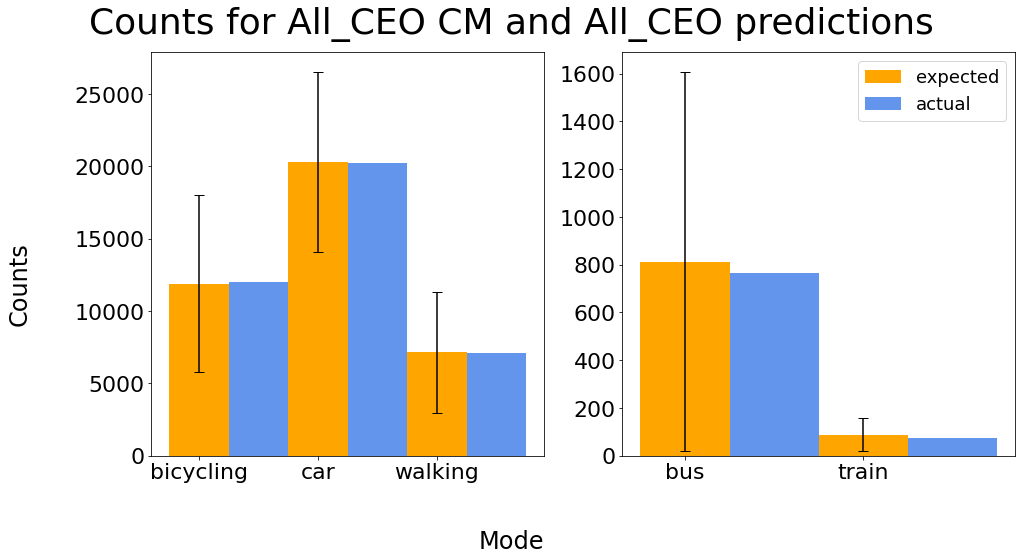

In [463]:
predictions = testing_trips.sum(axis=0)
(mean, var) = new_method(sampling_trips/sampling_trips.sum(axis=0), predictions)
print(pd.DataFrame({
    "actual": testing_trips.sum(axis=1),
    "predicted": predictions,
    "expected": mean,
    "variance": var,
    "sd from actual": (mean.subtract(testing_trips.sum(axis=1))).div(np.sqrt(var))
}))
plot_results(mean, testing_trips.sum(axis=1), var, "Counts", "Counts for All_CEO CM and All_CEO predictions")

# Making a confusion matrix w/ sklearn

In [ ]:
from sklearn.metrics import confusion_matrix

# go through primary_mode and mode_confirm to add values
ground_truth = []
predicted = []

for gt_mode, row in sampling_trips.iterrows():
    for sensed_mode in row.index:
        ground_truth.extend([str(gt_mode)]*int(row[sensed_mode]))
        predicted.extend([str(sensed_mode)]*int(row[sensed_mode]))

print(ground_truth)
print(predicted[0])

normalized_cm = confusion_matrix(ground_truth, predicted, labels=["bicycling", "bus", "car", "train", "walking"], normalize='true')

normalized_cm = pd.DataFrame(normalized_cm, columns=["bicycling", "bus", "car", "train", "walking"], index=["bicycling", "bus", "car", "train", "walking"])
print(normalized_cm)

In [420]:
predictions = testing_trips.sum(axis=0)
(mean, var) = new_method(normalized_cm, predictions)
print(pd.DataFrame({
    "actual": testing_trips.sum(axis=1),
    "predicted": predictions,
    "expected": mean,
    "variance": var,
    "sd from actual": (mean.subtract(testing_trips.sum(axis=1))).div(np.sqrt(var))
}))

row normalized probabilities:
            bicycling       bus       car     train   walking
bicycling   0.122963  0.000846  0.077813  0.000100  0.093236
bus         0.001368  0.000274  0.009926  0.000100  0.005821
car         0.012065  0.004403  0.416229  0.000274  0.072838
train       0.000149  0.000050  0.000672  0.000771  0.000473
walking     0.006592  0.000771  0.014478  0.000000  0.157790
            actual  predicted     expected     variance  sd from actual
bicycling  11947.0     5631.0  3562.098883  3234.507649     -147.432712
bus          827.0      276.0   292.860917   290.339320      -31.347393
car        20273.0    20903.0  9740.607154  6047.679114     -135.435551
train         84.0       56.0    21.237941    21.225374      -13.622898
walking     7066.0    13331.0  2443.465012  2106.927623     -100.706012


# all_ceo -> all_ceo distances

In [465]:
# get all_ceo trip data
all_ceo_trips = pd.read_csv("trip_data/all_ceo_trip_data.csv")

# split in half by OS, split each into two CMs
from sklearn.utils import shuffle
shuffled_trips = shuffle(all_ceo_trips)
shuffled_trips = helper.drop_unwanted_trips(shuffled_trips, drop_not_a_trip=True)

samplingCM = cm_handling.pair_matching(shuffled_trips.iloc[0:int(len(shuffled_trips.index)/2)], by_distances=True)
testingCM = cm_handling.pair_matching(shuffled_trips.iloc[int(len(shuffled_trips.index)/2):], by_distances=True)

samplingCM = cm_handling.map_labels(samplingCM, MODE_MAPPING_DICT)
testingCM = cm_handling.map_labels(testingCM, MODE_MAPPING_DICT)

print(samplingCM)
# print(testingCM)

Dropping user labeled AIR trips and trips with no OS.
Also dropping trips labeled as not a trip and trips with mode_confirm of nan.
                           walking           car     bicycling     no_sensed  \
Bikeshare             1.172086e+05  3.871564e+04  1.746313e+05  0.000000e+00   
Bus                   1.787665e+06  8.932842e+06  5.271288e+05  3.059133e+05   
Free Shuttle          2.136517e+04  4.751254e+05  5.621111e+03  2.874915e+03   
Gas Car, drove alone  6.621633e+06  8.494301e+07  1.545435e+06  4.010735e+06   
Gas Car, with others  1.286276e+07  1.572911e+08  3.477256e+06  7.119837e+06   
Pilot ebike           7.881059e+06  2.013104e+07  1.922137e+07  1.948531e+06   
Regular Bike          1.267352e+06  9.651238e+05  4.081097e+06  2.638026e+05   
Scooter share         3.893657e+04  9.915423e+04  3.791034e+04  6.121339e+03   
Skate board           5.374369e+03  4.240214e+03  2.575052e+04  7.258890e+03   
Taxi/Uber/Lyft        2.442815e+05  1.976579e+06  9.442850e+04  2.18

In [466]:
# make all CM gt modes map to base modes
# all_ceo_gt_to_sensed_mode_map = {
#     "bicycling":["Bikeshare", "Pilot ebike", "Regular Bike"],
#     "car": ["Gas Car, drove alone", "Gas Car, with others", "Taxi/Uber/Lyft"],
#     "train": ["Train"],
#     "walking": ["Walk"],
#     "bus": ["Bus", "Free Shuttle"]
# }

samplingCM = cm_handling.collapse_confusion_matrix(samplingCM, rows_to_collapse={
    "bicycling":["Bikeshare", "Pilot ebike", "Regular Bike"],
    "car": ["Gas Car, drove alone", "Gas Car, with others", "Taxi/Uber/Lyft"],
    "train": ["Train"],
    "walking": ["Walk"],
    "bus": ["Bus", "Free Shuttle"]
}, columns_to_collapse={})
samplingCM = cm_handling.drop_rows_and_columns(samplingCM, row_list=["Scooter share", "Skate board"], column_list=["no_sensed", "air_or_hsr", "subway"])
samplingCM = samplingCM.sort_index()

testingCM = cm_handling.collapse_confusion_matrix(testingCM, rows_to_collapse={
    "bicycling":["Bikeshare", "Pilot ebike", "Regular Bike"],
    "car": ["Gas Car, drove alone", "Gas Car, with others", "Taxi/Uber/Lyft", "E-car, drove alone"],
    "train": ["Train"],
    "walking": ["Walk"],
    "bus": ["Bus", "Free Shuttle"]
}, columns_to_collapse={})
testingCM = cm_handling.drop_rows_and_columns(testingCM, row_list=["Scooter share", "Skate board"], column_list=["no_sensed", "air_or_hsr", "subway"])
testingCM = testingCM.sort_index()


# put into km and round to int
samplingCM = (samplingCM/1000).astype(int)
testingCM = (testingCM/1000).astype(int)

print(samplingCM)
print(testingCM)

           walking     car  bicycling  bus  train
bicycling     9265   21134      23477   90    156
bus           1809    9407        532   84    121
car          19728  244210       5117  569    286
train          354    1078        140   20    889
walking       7217    2159        738   37      0
           walking     car  bicycling  bus  train
bicycling     9140   23770      23350   39    121
bus           1644    6793        583  236    154
car          18522  238686       4694  734     85
train          359     516         75   16   1559
walking       7095    2374        797   45      4


In [164]:
samplingCM = samplingCM.reindex(sorted(samplingCM), axis=1)
print(samplingCM.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  bicycling &  bus &     car &  train &  walking \\
\midrule
bicycling &      24149 &   77 &   22749 &    165 &     9166 \\
bus       &        436 &  130 &    8772 &    117 &     1942 \\
car       &       4974 &  510 &  238667 &    232 &    19940 \\
train     &         58 &   16 &    1027 &   1143 &      335 \\
walking   &        731 &   38 &    2299 &      0 &     7220 \\
\bottomrule
\end{tabular}



In [165]:
testingCM = testingCM.reindex(sorted(testingCM), axis=1)
print(testingCM.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  bicycling &  bus &     car &  train &  walking \\
\midrule
bicycling &      22678 &   53 &   22156 &    112 &     9239 \\
bus       &        680 &  190 &    7428 &    157 &     1510 \\
car       &       4837 &  793 &  244230 &    139 &    18303 \\
train     &        156 &   20 &     567 &   1305 &      377 \\
walking   &        804 &   44 &    2235 &      4 &     7092 \\
\bottomrule
\end{tabular}



probabilities:
             walking       car  bicycling      bus     train
bicycling  0.241446  0.076025   0.782462  0.11250  0.107438
bus        0.047143  0.033840   0.017731  0.10500  0.083333
car        0.514111  0.878491   0.170544  0.71125  0.196970
train      0.009225  0.003878   0.004666  0.02500  0.612259
walking    0.188075  0.007767   0.024597  0.04625  0.000000
           actual  predicted       expected         diff      variance  \
bicycling   56420      29499   52973.713304 -3446.286696  31161.423252   
bus          9410       1070   11737.677209  2327.677209  11309.924889   
car        262721     272139  264141.128937  1420.128937  42928.811554   
train        2525       1923    2736.205674   211.205674   2006.816079   
walking     10315      36760    9802.274875  -512.725125   8465.442539   

           sd from actual  
bicycling      -19.522829  
bus             21.887335  
car              6.854146  
train            4.714675  
walking         -5.572624  


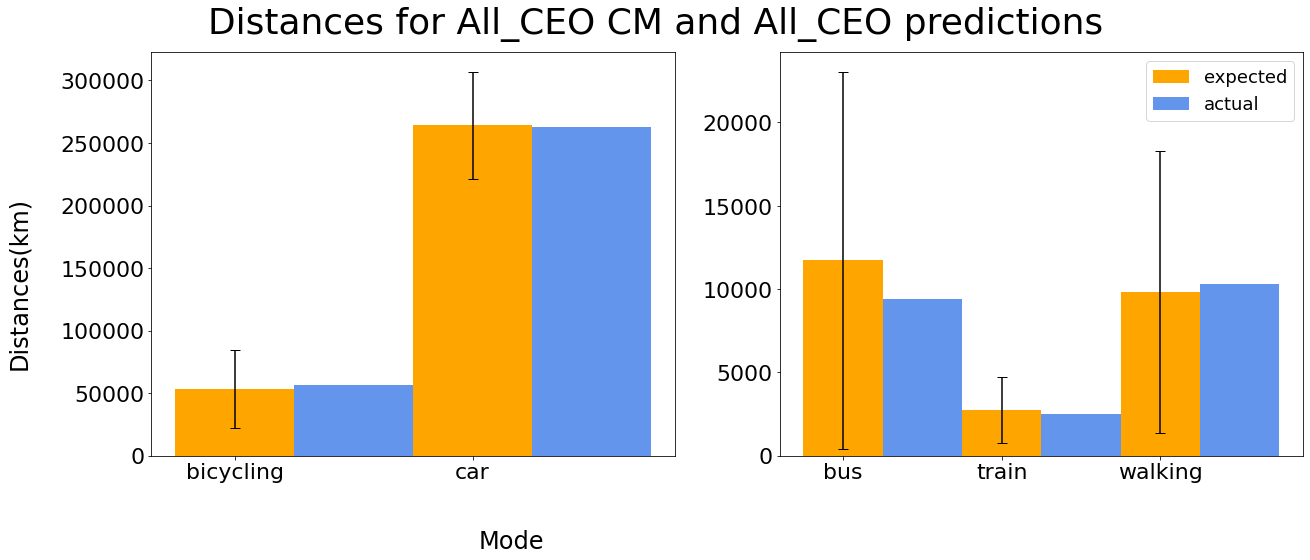

In [496]:
predictions = testingCM.sum(axis=0)
(mean, var) = new_method(samplingCM/samplingCM.sum(axis=0), predictions)
print(pd.DataFrame({
    "actual": testingCM.sum(axis=1),
    "predicted": predictions,
    "expected": mean,
    "diff":mean.subtract(testingCM.sum(axis=1)),
    "variance": var,
    "sd from actual": (mean.subtract(testingCM.sum(axis=1))).div(np.sqrt(var))
}))
plot_results(mean, testingCM.sum(axis=1), var, "Distances(km)", "Distances for All_CEO CM and All_CEO predictions")

# all_ceo -> durham distances

In [468]:
# get durham distances

durham_trip_data = pd.read_csv("trip_data/durham_trip_data.csv")

durham_distances = cm_handling.pair_matching(durham_trip_data, by_distances=True)
durham_distances = cm_handling.map_labels(durham_distances, MODE_MAPPING_DICT, remove_unknown=True)

all_ceo_gt_to_sensed_mode_map = {
    "bicycling":["Bikeshare", "Pilot ebike", "Regular Bike"],
    "car": ["Gas Car, drove alone", "Gas Car, with others", "Taxi/Uber/Lyft", "E-car, drove alone", "E-car, with others"],
    "train": ["Train"],
    "walking": ["Walk"],
    "bus": ["Bus", "Free Shuttle"]
}

durham_distances = cm_handling.collapse_confusion_matrix(durham_distances, rows_to_collapse=all_ceo_gt_to_sensed_mode_map, columns_to_collapse={})
durham_distances = cm_handling.drop_rows_and_columns(durham_distances, row_list=["Air", "Not a Trip", "Scooter share"], column_list=["no_sensed", "air_or_hsr", "subway"])
durham_distances = (durham_distances/1000).astype(int).sort_index()
print(durham_distances)
durham_distances = durham_distances.reindex(sorted(durham_distances.columns), axis=1)
print(durham_distances.to_latex())

           walking    car  train  bus  bicycling
bicycling     1107   4076      0  123       4276
bus            222    951      0  294         34
car           3075  39873      7   62       1469
train           58      0      0    0        241
walking        645    280      0    6         49
\begin{tabular}{lrrrrr}
\toprule
{} &  bicycling &  bus &    car &  train &  walking \\
\midrule
bicycling &       4276 &  123 &   4076 &      0 &     1107 \\
bus       &         34 &  294 &    951 &      0 &      222 \\
car       &       1469 &   62 &  39873 &      7 &     3075 \\
train     &        241 &    0 &      0 &      0 &       58 \\
walking   &         49 &    6 &    280 &      0 &      645 \\
\bottomrule
\end{tabular}



In [469]:
all_ceo_distances = testingCM + samplingCM
print(all_ceo_distances)
all_ceo_distances = all_ceo_distances.reindex(sorted(all_ceo_distances.columns), axis=1)
print(all_ceo_distances.to_latex())


           walking     car  bicycling   bus  train
bicycling    18405   44904      46827   129    277
bus           3453   16200       1115   320    275
car          38250  482896       9811  1303    371
train          713    1594        215    36   2448
walking      14312    4533       1535    82      4
\begin{tabular}{lrrrrr}
\toprule
{} &  bicycling &   bus &     car &  train &  walking \\
\midrule
bicycling &      46827 &   129 &   44904 &    277 &    18405 \\
bus       &       1115 &   320 &   16200 &    275 &     3453 \\
car       &       9811 &  1303 &  482896 &    371 &    38250 \\
train     &        215 &    36 &    1594 &   2448 &      713 \\
walking   &       1535 &    82 &    4533 &      4 &    14312 \\
\bottomrule
\end{tabular}



probabilities:
            bicycling       bus       car     train   walking
bicycling   0.786969  0.068984  0.081625  0.082074  0.244966
bus         0.018739  0.171123  0.029448  0.081481  0.045959
car         0.164882  0.696791  0.877790  0.109926  0.509097
train       0.003613  0.019251  0.002898  0.725333  0.009490
walking     0.025797  0.043850  0.008240  0.001185  0.190489
           actual  predicted      expected        diff     variance  \
bicycling    9582       6069   9748.992158  166.992158  5380.507165   
bus          1501        485   1762.448500  261.448500  1696.103054   
car         44486      45180  43597.898181 -888.101819  7061.828471   
train         299          7    215.717355  -83.282645   210.936380   
walking       980       5107   1522.943806  542.943806  1329.592185   

           sd from actual  
bicycling        2.276588  
bus              6.348338  
car            -10.568277  
train           -5.734278  
walking         14.890033  


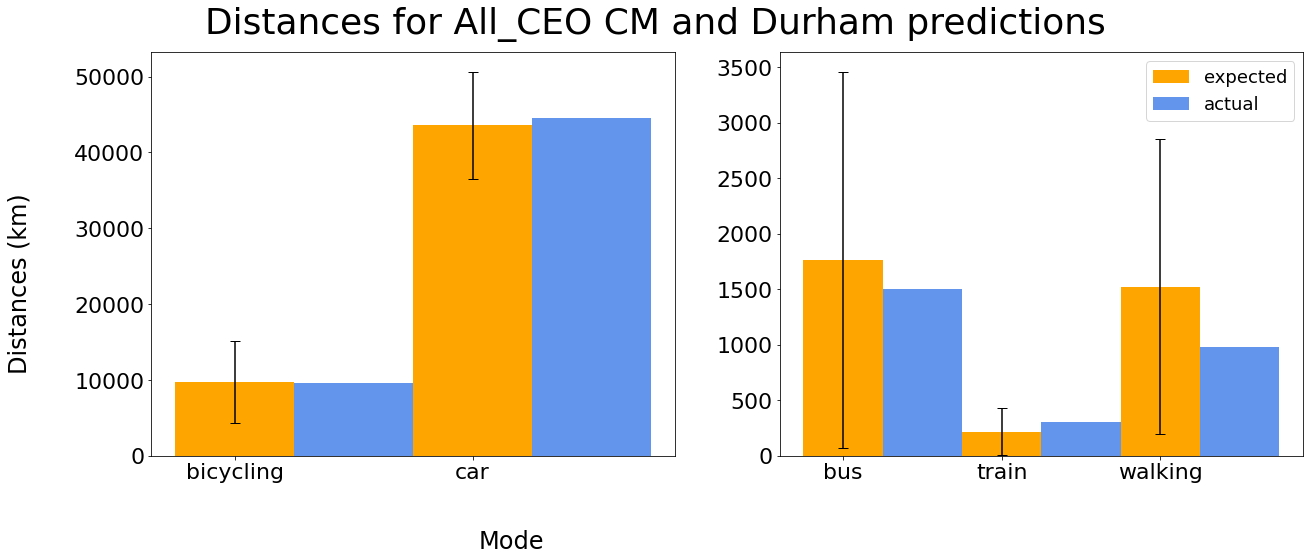

In [497]:
predictions = durham_distances.sum(axis=0)

(mean, var) = new_method(all_ceo_distances/all_ceo_distances.sum(axis=0), predictions)
print(pd.DataFrame({
    "actual": durham_distances.sum(axis=1),
    "predicted": predictions,
    "expected": mean,
    "diff":mean.subtract(durham_distances.sum(axis=1)),
    "variance": var,
    "sd from actual": (mean.subtract(durham_distances.sum(axis=1))).div(np.sqrt(var))
}))
plot_results(mean, durham_distances.sum(axis=1), var, "Distances (km)", "Distances for All_CEO CM and Durham predictions")

# durham -> all_ceo distances

In [155]:
all_ceo_distances = all_ceo_distances.reindex(sorted(all_ceo_distances.columns), axis=1)
durham_distances = durham_distances.reindex(sorted(durham_distances.columns), axis=1)
print(all_ceo_distances/all_ceo_distances.sum(axis=0))
print(durham_distances/durham_distances.sum(axis=0))

           bicycling       bus       car     train   walking
bicycling   0.786969  0.069482  0.081626  0.082098  0.244995
bus         0.018755  0.171032  0.029448  0.081209  0.045951
car         0.164882  0.696419  0.877787  0.109959  0.509065
train       0.003596  0.019241  0.002897  0.725548  0.009478
walking     0.025797  0.043827  0.008242  0.001186  0.190512
           bicycling       bus       car  train   walking
bicycling   0.705611  0.253608  0.093298    0.0  0.218904
bus         0.005611  0.606186  0.021768    0.0  0.043900
car         0.240924  0.127835  0.878525    1.0  0.598181
train       0.039769  0.000000  0.000000    0.0  0.011469
walking     0.008086  0.012371  0.006409    0.0  0.127546


probabilities:
            bicycling       bus       car  train   walking
bicycling   0.704564  0.253608  0.090217    0.0  0.216761
bus         0.005602  0.606186  0.021049    0.0  0.043470
car         0.242050  0.127835  0.882537    1.0  0.602115
train       0.039710  0.000000  0.000000    0.0  0.011357
walking     0.008074  0.012371  0.006197    0.0  0.126297
bicycling :
 bicycling    12385.757522
bus            353.974365
car          45153.224477
train            0.000000
walking      12755.768439
dtype: float64
bus :
 bicycling      331.482632
bus            446.415049
car          11335.955816
train            0.000000
walking       3124.039792
dtype: float64
car :
 bicycling    10916.520002
bus            208.492380
car          57029.361289
train            0.000000
walking      17999.806575
dtype: float64
train :
 bicycling    2269.034886
bus             0.000000
car             0.000000
train           0.000000
walking       843.591857
dtype: float64
walking :
 bicycling     

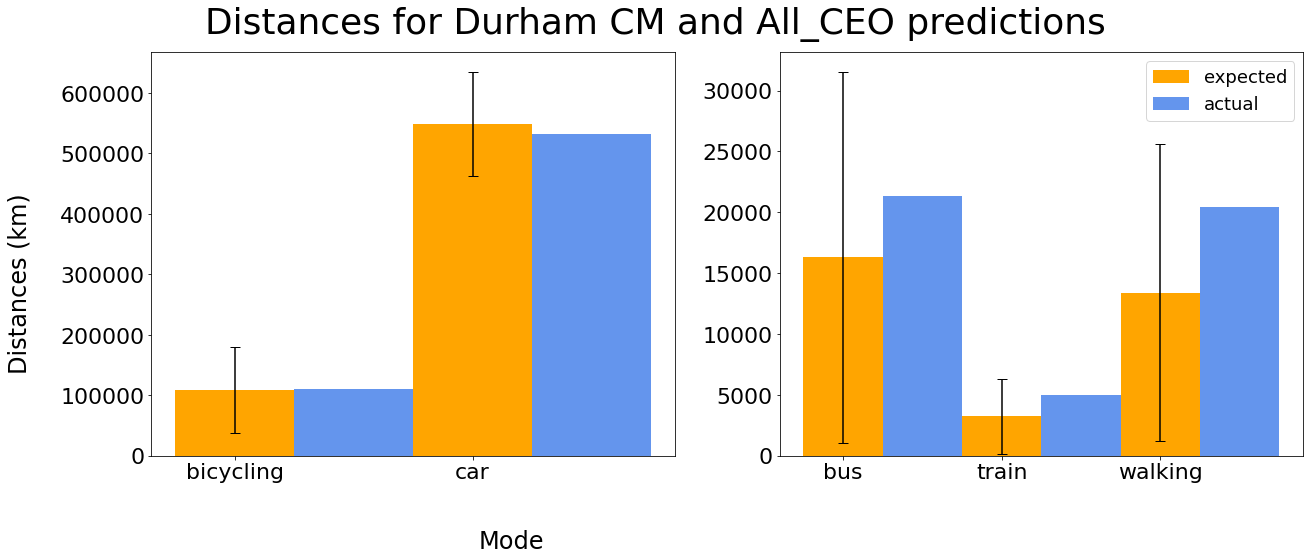

In [506]:
predictions = all_ceo_distances.sum(axis=0)

(mean, var) = new_method(durham_distances/durham_distances.sum(axis=0), predictions)
print(pd.DataFrame({
    "actual": all_ceo_distances.sum(axis=1),
    "predicted": predictions,
    "expected": mean,
    "diff":mean.subtract(all_ceo_distances.sum(axis=1)),
    "variance": var,
    "sd from actual": (mean.subtract(all_ceo_distances.sum(axis=1))).div(np.sqrt(var))
}))
plot_results(mean, all_ceo_distances.sum(axis=1), var, "Distances (km)", "Distances for Durham CM and All_CEO predictions")

# MobilityNet distance CM

In [110]:
sampling_android = pd.read_csv("MobilityNetCMs/mobilitynet_android.csv", index_col=0).T
sampling_ios = pd.read_csv("MobilityNetCMs/mobilitynet_ios.csv", index_col=0).T
mobilityNet_distances = sampling_android.add(sampling_ios)

# remove all no_gt and no_sensed
mobilityNet_distances = cm_handling.drop_rows_and_columns(mobilityNet_distances, row_list=["NO_GT_START", "NO_GT_MIDDLE", "NO_GT_END"], column_list=["NO_SENSED_START", "NO_SENSED_MIDDLE", "NO_SENSED_END"])

mn_gt_to_sensed_mode_map = {
    "walking":["WALKING"],
    "car":["CAR"],
    "bicycling":["BICYCLING", "E_BIKE"],
    "train":["TRAIN", "LIGHT_RAIL"],
    "bus":["BUS"]
}

mobilityNet_distances = cm_handling.collapse_confusion_matrix(mobilityNet_distances, rows_to_collapse=mn_gt_to_sensed_mode_map, columns_to_collapse={})
mobilityNet_distances = cm_handling.drop_rows_and_columns(mobilityNet_distances, row_list=["ESCOOTER", "SUBWAY"], column_list=["AIR_OR_HSR", "LIGHT_RAIL", "UNKNOWN", "SUBWAY"])
mobilityNet_distances.columns = map(lambda x: str(x).lower(), mobilityNet_distances.columns)
mobilityNet_distances = (mobilityNet_distances/1000).astype(int)
mobilityNet_distances = mobilityNet_distances.sort_index()

print(mobilityNet_distances/mobilityNet_distances.sum(axis=0))
print(all_ceo_distances/all_ceo_distances.sum(axis=0))

print(mobilityNet_distances)
mobilityNet_distances = mobilityNet_distances.reindex(sorted(mobilityNet_distances.columns), axis=1)
print(mobilityNet_distances.to_latex())

           bicycling       bus       car     train   walking
bicycling   0.372385  0.075058  0.046311  0.000000  0.059603
bus         0.163180  0.733256  0.139717  0.016903  0.370861
car         0.292887  0.001155  0.445840  0.000000  0.052980
train       0.075314  0.180139  0.361852  0.976415  0.271523
walking     0.096234  0.010393  0.006279  0.006682  0.245033
           bicycling       bus       car     train   walking
bicycling   0.786965  0.068910  0.081626  0.082123  0.244988
bus         0.018739  0.171474  0.029449  0.081233  0.045963
car         0.164885  0.696047  0.877784  0.109991  0.509051
train       0.003613  0.019765  0.002899  0.725467  0.009477
walking     0.025797  0.043803  0.008242  0.001186  0.190520
           bicycling  bus  car  train  walking
bicycling         89   65   59      0        9
bus               39  635  178     43       56
car               70    1  568      0        8
train             18  156  461   2484       41
walking           23    9    8   

# mobilitynet -> all_ceo distances

probabilities:
            bicycling       bus       car     train   walking
bicycling   0.372385  0.075058  0.046311  0.000000  0.059603
bus         0.163180  0.733256  0.139717  0.016903  0.370861
car         0.292887  0.001155  0.445840  0.000000  0.052980
train       0.075314  0.180139  0.361852  0.976415  0.271523
walking     0.096234  0.010393  0.006279  0.006682  0.245033
           actual  predicted       expected           diff       variance  \
bicycling  110542      59503   52253.343805  -58288.656195   42544.733847   
bus         21363       1870  115864.152068   94501.152068   92200.691210   
car        532631     550127  266678.925139 -265952.074861  152013.196904   
train        5006       3375  227578.802112  222572.802112  146391.682379   
walking     20466      75133   27632.776876    7166.776876   22548.594716   

           sd from actual  
bicycling     -282.592829  
bus            311.221803  
car           -682.123068  
train          581.719862  
walking        

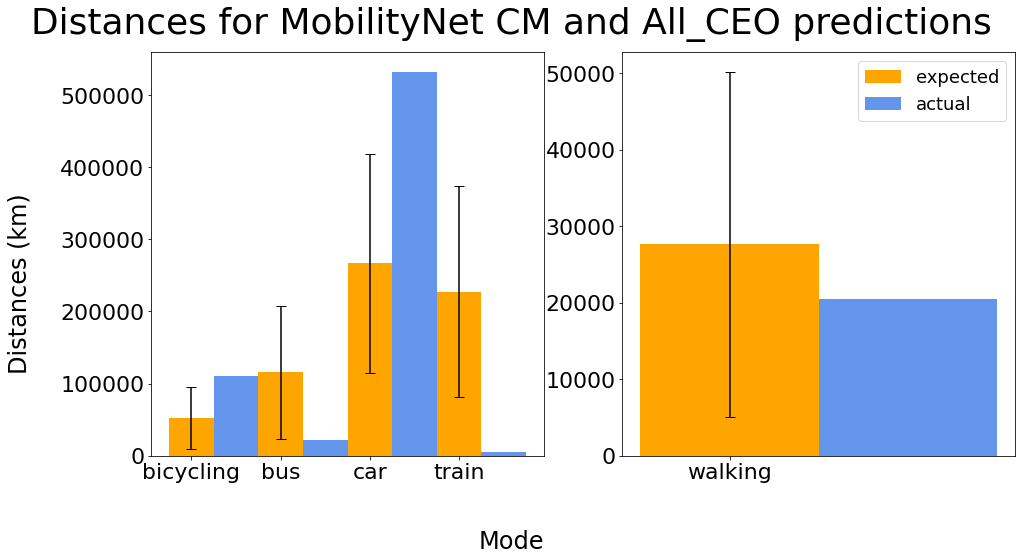

In [472]:
predictions = all_ceo_distances.sum(axis=0)
(mean, var) = new_method(mobilityNet_distances/mobilityNet_distances.sum(axis=0), predictions)
print(pd.DataFrame({
    "actual": all_ceo_distances.sum(axis=1),
    "predicted": predictions,
    "expected": mean,
    "diff":mean.subtract(all_ceo_distances.sum(axis=1)),
    "variance": var,
    "sd from actual": (mean.subtract(all_ceo_distances.sum(axis=1))).div(np.sqrt(var))
}))
plot_results(mean, all_ceo_distances.sum(axis=1), var, "Distances (km)", "Distances for MobilityNet CM and All_CEO predictions")

# mobilitynet -> durham distances

durham probs
             walking       car  train       bus  bicycling
bicycling  0.218904  0.093298    0.0  0.253608   0.705611
bus        0.043900  0.021768    0.0  0.606186   0.005611
car        0.598181  0.878525    1.0  0.127835   0.240924
train      0.011469  0.000000    0.0  0.000000   0.039769
walking    0.127546  0.006409    0.0  0.012371   0.008086
probabilities:
            bicycling       bus       car     train   walking
bicycling   0.372385  0.075058  0.046311  0.000000  0.059603
bus         0.163180  0.733256  0.139717  0.016903  0.370861
car         0.292887  0.001155  0.445840  0.000000  0.052980
train       0.075314  0.180139  0.361852  0.976415  0.271523
walking     0.096234  0.010393  0.006279  0.006682  0.245033
           actual  predicted      expected          diff      variance  \
bicycling    9582       6060   4617.693948  -4964.306052   3662.955914   
bus          1501        485   9324.036532   7823.036532   7353.542847   
car         42935      43688  2152

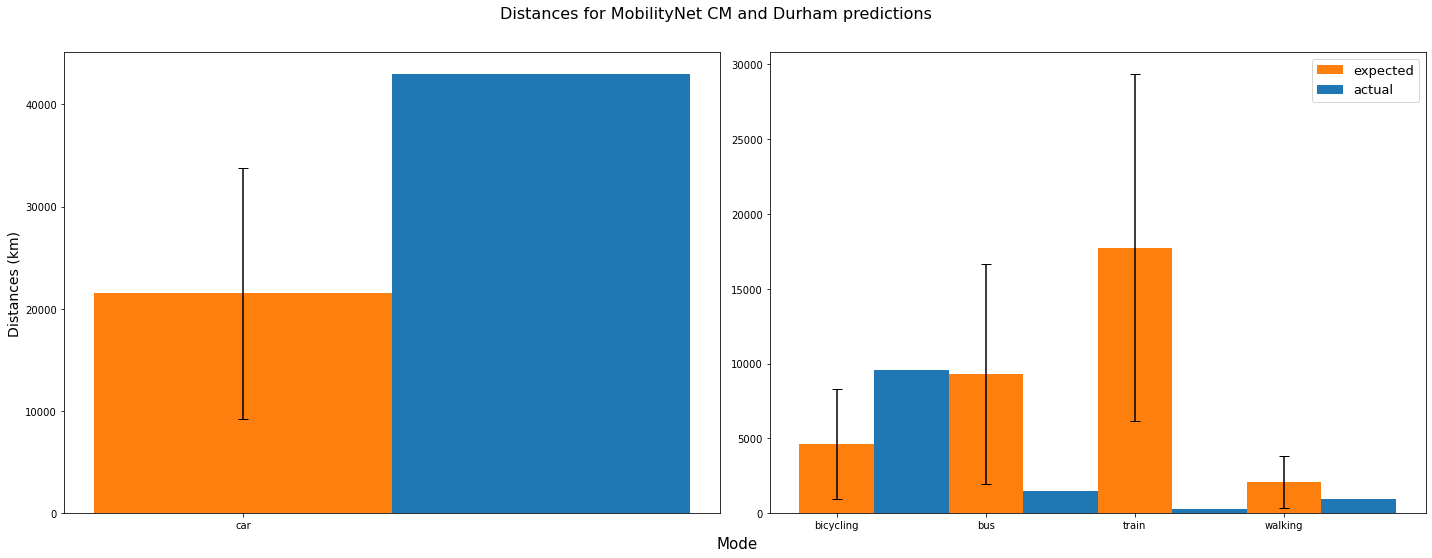

In [57]:
predictions = durham_distances.sum(axis=0)
print("durham probs\n", durham_distances/durham_distances.sum(axis=0))
(mean, var) = new_method(mobilityNet_distances/mobilityNet_distances.sum(axis=0), predictions)
print(pd.DataFrame({
    "actual": durham_distances.sum(axis=1),
    "predicted": predictions,
    "expected": mean,
    "diff":mean.subtract(durham_distances.sum(axis=1)),
    "variance": var,
    "sd from actual": (mean.subtract(durham_distances.sum(axis=1))).div(np.sqrt(var))
}))
plot_results(mean, durham_distances.sum(axis=1), var, "Distances (km)", "Distances for MobilityNet CM and Durham predictions")

# new mobility net -> all_ceo

In [123]:
new_mn = pd.read_csv("MobilityNetCMs/new_android_confusion.csv", index_col=0).add(pd.read_csv("MobilityNetCMs/new_ios_confusion.csv", index_col=0))
# print(new_mn)
newmn_tosensed_map = {
    "walking":["Walk"],
    "car":["Car, sensed"],
    "bicycling":["Regular Bike", "Pilot ebike"],
    "train":["Train"],
    "bus":["Bus"]
}
new_mn = cm_handling.collapse_confusion_matrix(new_mn, rows_to_collapse=newmn_tosensed_map, columns_to_collapse={})
new_mn = cm_handling.drop_rows_and_columns(new_mn, row_list=["no_gt", "Scooter share"], column_list=["no_sensed", "subway"])
new_mn = (new_mn/1000).astype(int)
new_mn.index.name = None

print(new_mn)

           walking  bicycling  car  bus  train
walking         56          1    0    0      0
car              1          0  238    0      0
bicycling        0         98    0    0      0
train            7          2   94   18   1044
bus              4          0  140  231      0


In [120]:
print(all_ceo_distances)

           bicycling   bus     car  train  walking
bicycling      46826   129   44905    277    18405
bus             1115   321   16201    274     3453
car             9811  1303  482897    371    38243
train            215    37    1595   2447      712
walking         1535    82    4534      4    14313


probabilities:
            bicycling       bus       car  train   walking
bicycling   0.970297  0.000000  0.000000    0.0  0.000000
bus         0.000000  0.927711  0.296610    0.0  0.058824
car         0.000000  0.000000  0.504237    0.0  0.014706
train       0.019802  0.072289  0.199153    1.0  0.102941
walking     0.009901  0.000000  0.000000    0.0  0.823529
           actual  predicted       expected           diff       variance  \
bicycling  110542      59503   57735.584158  -52806.415842    1714.918341   
bus         21363       1870  169327.670224  147964.670224  119059.434682   
car        532631     550127  278499.443669 -254131.556331  138610.521257   
train        5006       3375  121981.928040  116975.928040   95958.656532   
walking     20466      75133   62463.373908   41997.373908   11502.288257   

           sd from actual  
bicycling    -1275.160845  
bus            428.821076  
car           -682.590906  
train          377.619506  
walking        391.588574  


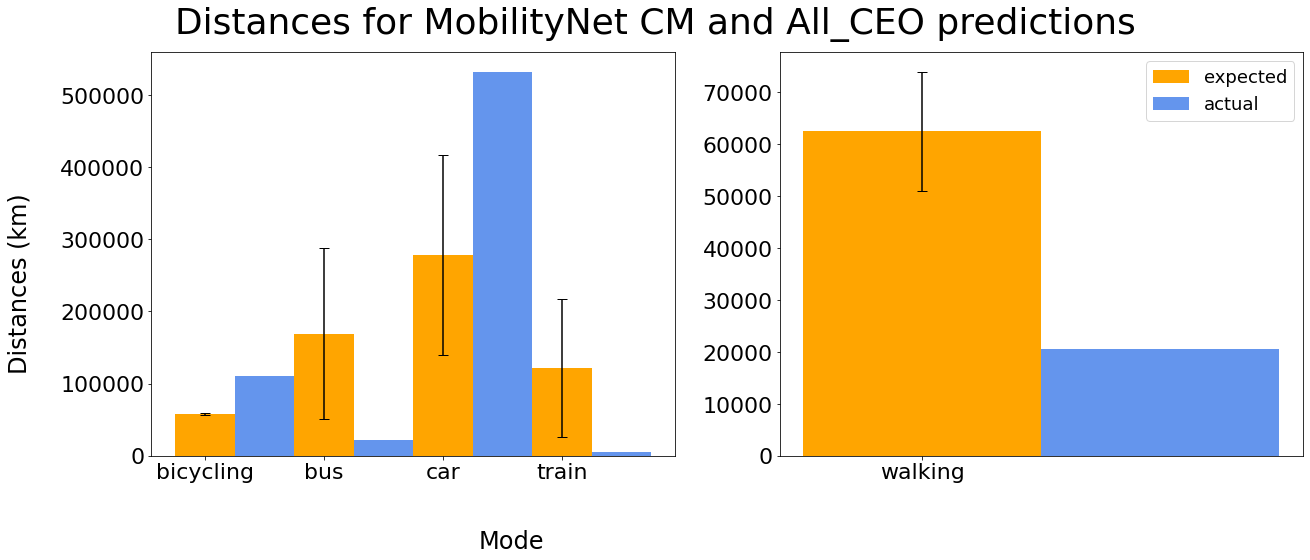

In [494]:
predictions = all_ceo_distances.sum(axis=0)
(mean, var) = new_method(new_mn/new_mn.sum(axis=0), predictions)
print(pd.DataFrame({
    "actual": all_ceo_distances.sum(axis=1),
    "predicted": predictions,
    "expected": mean,
    "diff":mean.subtract(all_ceo_distances.sum(axis=1)),
    "variance": var,
    "sd from actual": (mean.subtract(all_ceo_distances.sum(axis=1))).div(np.sqrt(var))
}))
plot_results(mean, all_ceo_distances.sum(axis=1), var, "Distances (km)", "Distances for MobilityNet CM and All_CEO predictions")

# new mn -> durham

probabilities:
            bicycling       bus       car  train   walking
bicycling   0.970297  0.000000  0.000000    0.0  0.000000
bus         0.000000  0.927711  0.296610    0.0  0.058824
car         0.000000  0.000000  0.504237    0.0  0.014706
train       0.019802  0.072289  0.199153    1.0  0.102941
walking     0.009901  0.000000  0.000000    0.0  0.823529
           actual  predicted      expected          diff      variance  \
bicycling    9582       6069   5888.732673  -3693.267327    174.912852   
bus          1501        485  14151.198981  12650.198981   9741.286072   
car         44486      45180  22856.543619 -21629.456381  11368.187297   
train         299          7   9685.670911   9386.670911   7827.721180   
walking       980       5107   4265.853815   3285.853815    801.687939   

           sd from actual  
bicycling     -279.254309  
bus            128.170833  
car           -202.861669  
train          106.094756  
walking        116.050112  


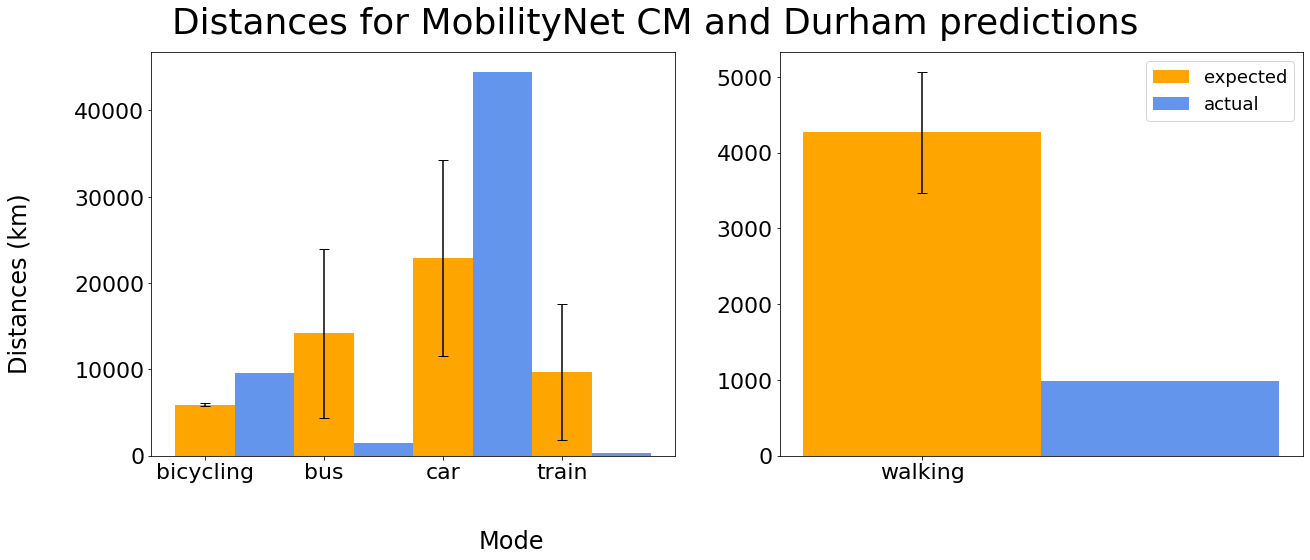

In [495]:
predictions = durham_distances.sum(axis=0)
(mean, var) = new_method(new_mn/new_mn.sum(axis=0), predictions)
print(pd.DataFrame({
    "actual": durham_distances.sum(axis=1),
    "predicted": predictions,
    "expected": mean,
    "diff":mean.subtract(durham_distances.sum(axis=1)),
    "variance": var,
    "sd from actual": (mean.subtract(durham_distances.sum(axis=1))).div(np.sqrt(var))
}))
plot_results(mean, durham_distances.sum(axis=1), var, "Distances (km)", "Distances for MobilityNet CM and Durham predictions")

# making heatmaps of CMs

In [481]:
print(all_ceo_counts)

           bicycling    bus      car  train  walking
bicycling     9766.0   73.0   6374.0   10.0   7581.0
bus            114.0   30.0    891.0    9.0    535.0
car           1008.0  359.0  33309.0   21.0   5910.0
train           15.0    2.0     45.0   66.0     41.0
walking        485.0   68.0   1173.0    2.0  12559.0


           bicycling       bus       car     train   walking
bicycling   0.857569  0.137218  0.152517  0.092593  0.284722
bus         0.010011  0.056391  0.021320  0.083333  0.020093
car         0.088514  0.674812  0.797019  0.194444  0.221963
train       0.001317  0.003759  0.001077  0.611111  0.001540
walking     0.042589  0.127820  0.028068  0.018519  0.471682


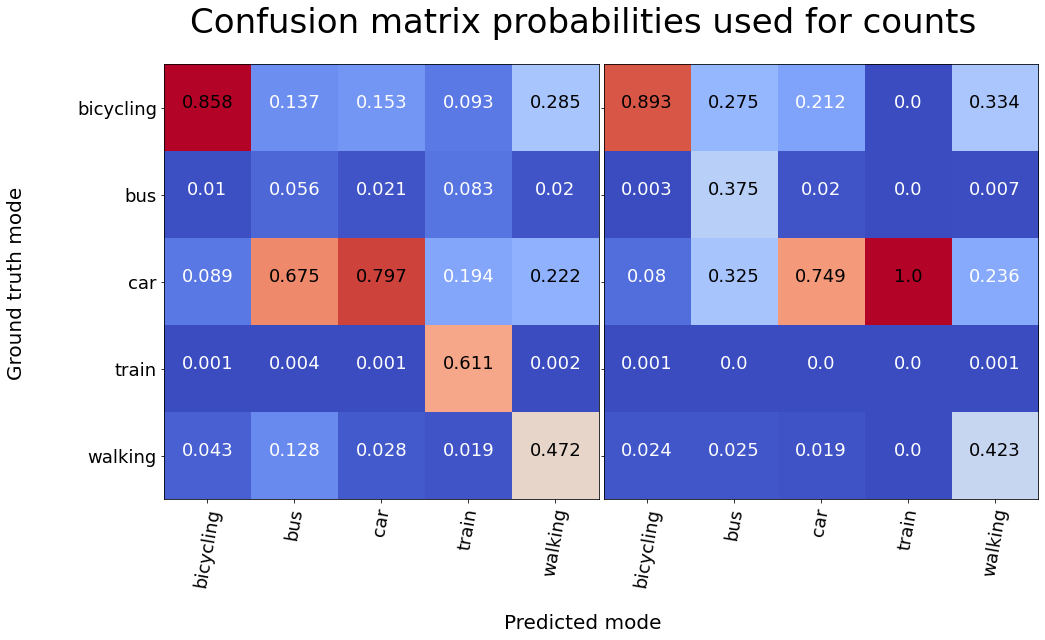

In [484]:
# counts
import itertools
data = [all_ceo_counts, durham_counts, sampling_trips, testing_trips]

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
print(all_ceo_counts/all_ceo_counts.sum(axis=0))
for i, ax in enumerate(axes.flat):
    ax.imshow((data[i]/data[i].sum(axis=0)).round(3), interpolation="nearest", cmap="coolwarm")
    ax.set_yticks(np.arange(len(data[i].columns)))
    ax.set_xticks(np.arange(len(data[i])))
    ax.set_yticklabels(data[i], fontsize=18)
    ax.set_xticklabels(data[i].index, rotation=80, fontsize=18)

    nums = (data[i]/data[i].sum(axis=0)).round(3)
    color_thresh = nums.max().max() / 4
    for k, j in itertools.product(range(data[i].shape[1]), range(data[i].shape[0])  ):
        ax.text(j, k, nums.iat[k,j], horizontalalignment='center', fontsize=18,
                   color='white' 
                       if nums.iat[k,j] < color_thresh 
#                            or df.transpose().iat[i,j] in df.max()
                       else 'black')

plt.subplots_adjust(wspace=-.35, hspace=0)
fig.suptitle("Confusion matrix probabilities used for counts", fontsize=34)
fig.text(0.5, -0.1, 'Predicted mode', ha='center').set_fontsize(20)
fig.text(0.1, 0.5, 'Ground truth mode', va='center', rotation='vertical').set_fontsize(20)
plt.show()


           bicycling       bus       car     train   walking
bicycling   0.857569  0.137218  0.152517  0.092593  0.284732
bus         0.010011  0.056391  0.021320  0.083333  0.020094
car         0.088514  0.674812  0.797019  0.194444  0.221934
train       0.001317  0.003759  0.001077  0.611111  0.001540
walking     0.042589  0.127820  0.028068  0.018519  0.471700


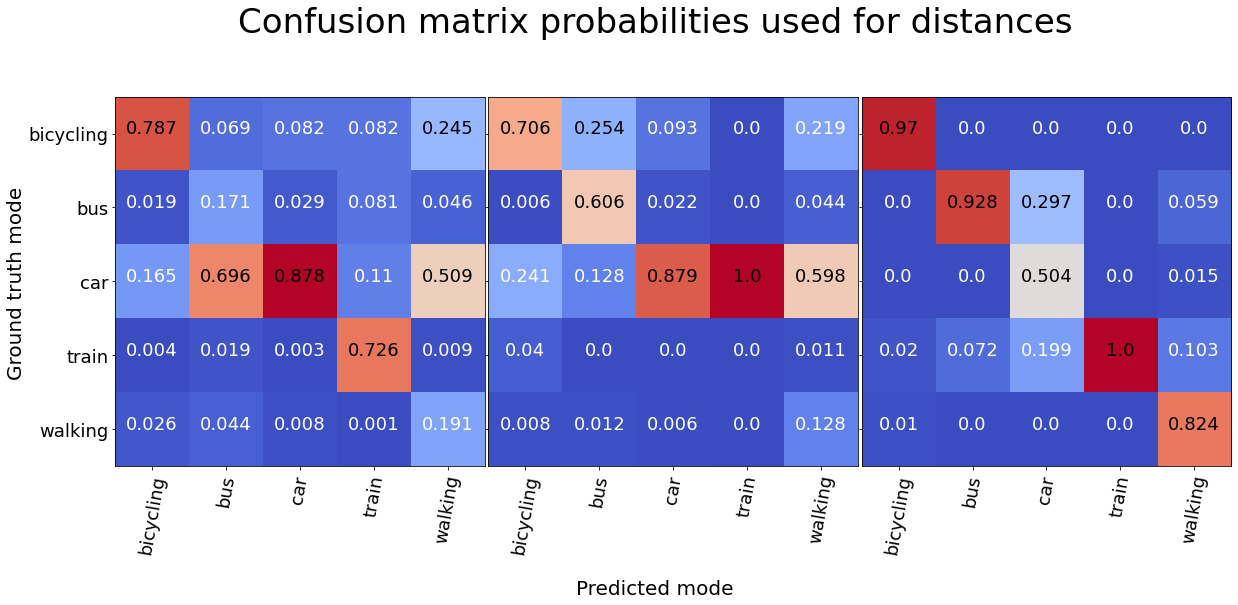

In [392]:
# distances
import itertools

data = [all_ceo_distances, durham_distances, new_mn, samplingCM, testingCM]

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)


print(all_ceo_counts/all_ceo_counts.sum(axis=0))
for i, ax in enumerate(axes.flat):
    ax.imshow((data[i]/data[i].sum(axis=0)).round(3), interpolation="nearest", cmap="coolwarm")
    ax.set_yticks(np.arange(len(data[i].columns)))
    ax.set_xticks(np.arange(len(data[i])))
    ax.set_yticklabels(data[i], fontsize=18)
    ax.set_xticklabels(data[i].index, rotation=80, fontsize=18)
    
    nums = (data[i]/data[i].sum(axis=0)).round(3)
    color_thresh = nums.max().max() / 4
    for k, j in itertools.product(range(data[i].shape[1]), range(data[i].shape[0])  ):
        ax.text(j, k, nums.iat[k,j], horizontalalignment='center', fontsize=18,
                   color='white' 
                       if nums.iat[k,j] < color_thresh 
                       else 'black')

plt.subplots_adjust(wspace=0.01, hspace=0)
fig.suptitle("Confusion matrix probabilities used for distances", fontsize=34)
fig.text(0.5, -0.04, 'Predicted mode', ha='center').set_fontsize(20)
fig.text(0.05, 0.5, 'Ground truth mode', va='center', rotation='vertical').set_fontsize(20)
plt.show()

In [325]:
# tables of probabilities
new_mn = new_mn.sort_index()
new_mn = new_mn.reindex(sorted(new_mn.columns), axis=1)
print((new_mn/new_mn.sum(axis=0)).round(2).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  bicycling &   bus &  car &  train &  walking \\
\midrule
bicycling &       0.97 &  0.00 &  0.0 &    0.0 &     0.00 \\
bus       &       0.00 &  0.93 &  0.3 &    0.0 &     0.06 \\
car       &       0.00 &  0.00 &  0.5 &    0.0 &     0.01 \\
train     &       0.02 &  0.07 &  0.2 &    1.0 &     0.10 \\
walking   &       0.01 &  0.00 &  0.0 &    0.0 &     0.82 \\
\bottomrule
\end{tabular}



In [499]:
all_ceo_counts

,bicycling,bus,car,train,walking
bicycling,9766.0,73.0,6374.0,10.0,7581.0
bus,114.0,30.0,891.0,9.0,535.0
car,1008.0,359.0,33309.0,21.0,5910.0
train,15.0,2.0,45.0,66.0,41.0
walking,485.0,68.0,1173.0,2.0,12559.0


In [500]:
durham_counts

,bicycling,bus,car,train,walking
bicycling,1063.0,11.0,627.0,0.0,596.0
bus,3.0,15.0,58.0,0.0,12.0
car,95.0,13.0,2214.0,2.0,421.0
train,1.0,0.0,0.0,0.0,2.0
walking,28.0,1.0,55.0,0.0,755.0


# Checks before using method

## Is it a multinomial?

In [135]:
from scipy.stats import multinomial
predicted_bike_prob = [0.8, 0.1, 0.1] #bike, walk, car
predicted_walk_prob = [0.05, 0.75, 0.2]
predicted_car_prob =  [0.15, 0.15, 0.7]

n_bike_predicted = 5
n_walk_predicted = 3
n_car_predicted = 2


# P(true bike count = 0 while 5 bikes were predicted) should be .00017
true_bike0 = (multinomial.pmf([0, 0, 5], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 1, 4], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 2, 3], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 3, 2], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 4, 1], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 5, 0], n_bike_predicted, predicted_bike_prob)) * \
            (multinomial.pmf([0, 3, 0], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([0, 2, 1], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([0, 1, 2], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([0, 0, 3], n_walk_predicted, predicted_walk_prob)) * \
            (multinomial.pmf([0, 2, 0], n_car_predicted, predicted_car_prob) + \
             multinomial.pmf([0, 1, 1], n_car_predicted, predicted_car_prob) + \
             multinomial.pmf([0, 0, 2], n_car_predicted, predicted_car_prob))

print(true_bike0)

true_bike1_bb_1 = (multinomial.pmf([1, 0, 4], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([1, 1, 3], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([1, 2, 2], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([1, 3, 1], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([1, 4, 0], n_bike_predicted, predicted_bike_prob)) * \
            (multinomial.pmf([0, 3, 0], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([0, 2, 1], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([0, 1, 2], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([0, 0, 3], n_walk_predicted, predicted_walk_prob)) * \
            (multinomial.pmf([0, 2, 0], n_car_predicted, predicted_car_prob) + \
             multinomial.pmf([0, 1, 1], n_car_predicted, predicted_car_prob) + \
             multinomial.pmf([0, 0, 2], n_car_predicted, predicted_car_prob))
true_bike1_bw_1 = (multinomial.pmf([0, 0, 5], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 1, 4], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 2, 3], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 3, 2], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 4, 1], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 5, 0], n_bike_predicted, predicted_bike_prob)) * \
            (multinomial.pmf([1, 2, 0], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([1, 1, 1], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([1, 0, 2], n_walk_predicted, predicted_walk_prob)) * \
            (multinomial.pmf([0, 2, 0], n_car_predicted, predicted_car_prob) + \
             multinomial.pmf([0, 1, 1], n_car_predicted, predicted_car_prob) + \
             multinomial.pmf([0, 0, 2], n_car_predicted, predicted_car_prob))
true_bike1_bc_1 = (multinomial.pmf([0, 0, 5], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 1, 4], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 2, 3], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 3, 2], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 4, 1], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 5, 0], n_bike_predicted, predicted_bike_prob)) * \
            (multinomial.pmf([0, 3, 0], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([0, 2, 1], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([0, 1, 2], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([0, 0, 3], n_walk_predicted, predicted_walk_prob)) * \
            (multinomial.pmf([1, 1, 0], n_car_predicted, predicted_car_prob) + \
             multinomial.pmf([1, 0, 1], n_car_predicted, predicted_car_prob))
print(true_bike1_bb_1+true_bike1_bw_1+true_bike1_bc_1)

# ten bike trips
ten_bikes = multinomial.pmf([5, 0, 0], n_bike_predicted, predicted_bike_prob) * \
            multinomial.pmf([3, 0, 0], n_walk_predicted, predicted_walk_prob) * \
            multinomial.pmf([2, 0, 0], n_car_predicted, predicted_car_prob)
print(ten_bikes)

0.00019822509999999988
0.004065762499999998
9.216000000000003e-07


In [144]:
print((multinomial.pmf([0, 0, 5], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 1, 4], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 2, 3], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 3, 2], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 4, 1], n_bike_predicted, predicted_bike_prob) + \
            multinomial.pmf([0, 5, 0], n_bike_predicted, predicted_bike_prob)), \
            (multinomial.pmf([0, 3, 0], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([0, 2, 1], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([0, 1, 2], n_walk_predicted, predicted_walk_prob) + \
            multinomial.pmf([0, 0, 3], n_walk_predicted, predicted_walk_prob)), \
            (multinomial.pmf([1, 1, 0], n_car_predicted, predicted_car_prob) + \
             multinomial.pmf([1, 0, 1], n_car_predicted, predicted_car_prob)))
print(true_bike1_bc_1)

0.00031999999999999986 0.857375 0.255
6.996179999999996e-05


In [ ]:
import scipy
import pandas as pd

NMC = 5*10**4

# columns of CMs
vectors_given_bike = scipy.stats.multinomial.rvs(5, p = [0.8, 0.1, 0.1], size= NMC, random_state=None)
vectors_given_car = scipy.stats.multinomial.rvs(2, p = [0.05, 0.9, 0.05], size= NMC, random_state=None)
vectors_given_walk = scipy.stats.multinomial.rvs(3, p = [0.2, 0.1, 0.7], size= NMC, random_state=None)

# dataframe with actual counts for each CM. NMC rows long, columns are bike, walk, car
actual_counts = pd.DataFrame()

for i in range(0, NMC):
    # make dataframe with columns at i in each list, sum over rows to get actual counts
    cm = pd.DataFrame({"bike":vectors_given_bike[i], "walk":vectors_given_walk[i], "car":vectors_given_car[i]})
    counts = cm.sum(axis = 1)
    #add to dataframe
    actual_counts = actual_counts.append(counts, ignore_index=True)


In [143]:
actual_counts.columns = ["bike", "walk", "car"]
print(actual_counts[actual_counts.bike==10])
print(actual_counts[actual_counts.bike==10].shape[0]/NMC)

       bike  walk  car
43114  10.0   0.0  0.0
2e-05


## Validating combination of variances and means is correct

In [239]:
import scipy
import pandas as pd

predicted_bike_prob = [0.8, 0.1, 0.1] #bike, walk, car
predicted_walk_prob = [0.05, 0.75, 0.2]
predicted_car_prob =  [0.15, 0.15, 0.7]

NMC = 1000

# columns
rv_given_bike = pd.DataFrame(scipy.stats.multinomial.rvs(5, p = predicted_bike_prob, size= NMC, random_state=None), columns=["bike", "walk", "car"])
rv_given_car = pd.DataFrame(scipy.stats.multinomial.rvs(2, p = predicted_car_prob, size= NMC, random_state=None), columns=["bike", "walk", "car"])
rv_given_walk = pd.DataFrame(scipy.stats.multinomial.rvs(3, p = predicted_walk_prob, size= NMC, random_state=None), columns=["bike", "walk", "car"])

all_rvs = rv_given_bike+rv_given_car+rv_given_walk
print(all_rvs)

print(pd.DataFrame({
    "added means":rv_given_bike.mean().add(rv_given_car.mean()).add(rv_given_walk.mean()),
    "mean of added":all_rvs.mean(axis=0),
    "added var": rv_given_bike.var().add(rv_given_car.var()).add(rv_given_walk.var()),
    "var of added":all_rvs.var(axis=0)
}))

     bike  walk  car
0       5     3    2
1       4     4    2
2       5     2    3
3       4     2    4
4       2     2    6
..    ...   ...  ...
995     4     4    2
996     5     2    3
997     6     3    1
998     2     3    5
999     4     2    4

[1000 rows x 3 columns]
      added means  mean of added  added var  var of added
bike        4.409          4.409   1.217577      1.226946
walk        3.072          3.072   1.281908      1.312128
car         2.519          2.519   1.366708      1.367006
